## Motivation
 - Inductive biases of protein structures respected by AlphaFold
 - Neural network initialization and training tricks
   - Binning real values (see https://twitter.com/SassSeabass/status/1563303080069738496)  
     - pLDDT prediction
     - Distograms
     - RBF input features
   - More tricks on pg.44 of the supplemental
 - Reusable AlphaFold modules  
   - A protein structure thought of as a gas of residue frames and torsion angles
   - MSA attention
   - Triangle attention
   - Invariant point attention
   - Transition block
 - Understand AlphaFold by rewriting its operations with `einsum`

## You can learn a representation for anything:  


*   Single sequence
*   Multiple sequence alignment
*   Residue-residue pairs (shares info with residue-residue distance)

**Use auxiliary losses to ensure representations are meaningful**




## Setup

In [ ]:
!pip install einops
!pip install biopython
!wget https://files.rcsb.org/download/7EOW.pdb

import itertools

from Bio.PDB import PDBParser, Selection

from einops import rearrange, reduce, repeat

import numpy as np
import torch
import torch.nn as nn

import plotly.express as px

parser = PDBParser()
structure = parser.get_structure("caplacizumab", "/content/7EOW.pdb")[0]["B"]
for res in Selection.unfold_entities(structure, "R"):
    if res.get_id()[0] != " ":
        res.get_parent().detach_child(res.get_id())


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-08-29 16:21:49--  https://files.rcsb.org/download/7EOW.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7EOW.pdb.1’

7EOW.pdb.1              [          <=>       ] 502.37K   235KB/s    in 2.1s    

2022-08-29 16:21:51 (235 KB/s) - ‘7EOW.pdb.1’ saved [514431]



/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5966.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6161.
  PDBConstructionWarning,


In [ ]:
# constants
batch_size = 4
Nseq = 10
L = 18
cs = 384
cm = 256
c_msa_attn = 32
c_outer_product = 32
cz = 128
c_triangle_mult = 128
c_triangle_attn = 32
c_ipa = 16
c_structure_module = 128
Nhead_triangle = 4
Nhead_msa = 8
Nhead_ipa = 12
Nquery_pts = 4
Nvalue_pts = 8
Nevoformer_blocks = 48
Nstructure_module = 8


## Keeping gradients in control

### Gradient clipping  
https://stackoverflow.com/a/54816498

In [ ]:
params = nn.Parameter(torch.randn(128, 128), requires_grad=True)
input = torch.randn(128,)
relu = nn.ReLU()
out = params @ input
loss = torch.sum(relu(out[:-2] - out[2:]))
loss.backward()

fig = px.imshow(params.grad)
fig.show()

In [ ]:
# clip individual gradient values during backprop
norm = 0.1
params = nn.Parameter(torch.randn(128, 128), requires_grad=True)
params.register_hook(lambda grad: torch.clamp(grad, -norm, norm))

input = torch.randn(128,)
relu = nn.ReLU()
out = params @ input
loss = torch.sum(relu(out[:-2] - out[2:]))
loss.backward()

fig = px.imshow(params.grad)
fig.show()


In [ ]:
# compute gradients, then clip by the norm over all gradient entries
norm = 1.0
params = nn.Parameter(torch.randn(128, 128), requires_grad=True)

input = torch.randn(128,)
relu = nn.ReLU()
out = params @ input
loss = torch.sum(relu(out[:-2] - out[2:]))
loss.backward()
nn.utils.clip_grad_norm_(params, norm)

fig = px.imshow(params.grad)
fig.show()


### Ensuring values are not too large



In [ ]:
params = nn.Parameter(torch.randn(128, 128), requires_grad=True)
input = 100 * torch.randn(128,) # increase variance of input values
relu = nn.ReLU()
out = params @ input
loss = torch.sum(relu(out[:-2] - out[2:]))
loss.backward()

fig = px.imshow(params.grad)
fig.show()

Layer Normalization  

$$ \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}}*\gamma  + \beta $$

In [ ]:
params = nn.Parameter(torch.randn(128, 128), requires_grad=True)
input = 100 * torch.randn(128,) # increase variance of input values
layer_norm = nn.LayerNorm(128)
relu = nn.ReLU()
out = layer_norm(params @ input)
loss = torch.sum(relu(out[:-2] - out[2:]))
loss.backward()

fig = px.imshow(params.grad)
fig.show()

Predict $(\cos\theta, \sin\theta)$ instead of directly predicting $\theta$

http://bioinformatics.org/molvis/phipsi/

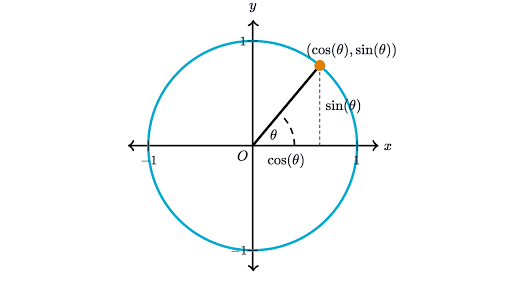

Binning real values as "one-hot"

In [ ]:
# Algorithm 5
def one_hot(x, v_bins):
    Nbins = len(v_bins)
    p = torch.zeros(Nbins)
    b = torch.argmin(torch.abs(x - v_bins))
    p[b] = 1.0
    return p

Encode distances as:  
  - Distograms (stacks of distance matrices)
  - Series of radial basis functions (not in AlphaFold but present in ProteinMPNN)

Use whiteboard

In [ ]:
def distogram_one_hot(structure, v_bins):
    atoms = [res["CA"] if res.get_resname() == "GLY" else res["CB"] for res in Selection.unfold_entities(structure, "R")]
    Nres = len(atoms)
    Nbins = len(v_bins)
    distogram = torch.zeros(Nres, Nres, Nbins)
    for i, j in itertools.product(range(Nres), range(Nres)):
        distance = atoms[i] - atoms[j]
        distogram[i, j] = one_hot(distance, v_bins)
    return distogram


In [ ]:
v_bins = torch.linspace(3.25, 50.75, 39) # for template features
v_bins

tensor([ 3.2500,  4.5000,  5.7500,  7.0000,  8.2500,  9.5000, 10.7500, 12.0000,
        13.2500, 14.5000, 15.7500, 17.0000, 18.2500, 19.5000, 20.7500, 22.0000,
        23.2500, 24.5000, 25.7500, 27.0000, 28.2500, 29.5000, 30.7500, 32.0000,
        33.2500, 34.5000, 35.7500, 37.0000, 38.2500, 39.5000, 40.7500, 42.0000,
        43.2500, 44.5000, 45.7500, 47.0000, 48.2500, 49.5000, 50.7500])

In [ ]:
v_bins = torch.linspace(3 + 3/8, 21 + 3/8, 16) # for recycling step
v_bins

tensor([ 3.3750,  4.5750,  5.7750,  6.9750,  8.1750,  9.3750, 10.5750, 11.7750,
        12.9750, 14.1750, 15.3750, 16.5750, 17.7750, 18.9750, 20.1750, 21.3750])

In [ ]:
distogram = distogram_one_hot(structure, v_bins)
distogram.shape

torch.Size([128, 128, 16])

In [ ]:
fig = px.imshow(distogram[:, :, 10])
fig.show()

In [ ]:
def distogram_rbf(structure, v_bins):
    atoms = [res["CA"] if res.get_resname() == "GLY" else res["CB"] for res in Selection.unfold_entities(structure, "R")]
    Nres = len(atoms)
    Nbins = len(v_bins)
    sigma = (torch.max(v_bins) - torch.min(v_bins)) / len(v_bins)
    distogram = torch.zeros(Nres, Nres, Nbins)
    for i, j in itertools.product(range(Nres), range(Nres)):
        distance = atoms[i] - atoms[j]
        distogram[i, j] = torch.exp(-((distance - v_bins) / sigma)**2)
    return distogram


In [ ]:
distogram = distogram_rbf(structure, v_bins)
distogram.shape

torch.Size([128, 128, 16])

In [ ]:
fig = px.imshow(distogram[:, :, 5])
fig.show()

## Resnet Initialization
Initialize final layer of resnet to all zeros so it starts as the identity function:  
$$ \mathbf{x} \leftarrow \mathbf{x} + \text{MLP}(\mathbf{x}) $$  
$$ \mathbf{x} \leftarrow \mathbf{x} + \mathbf{0} $$

In [ ]:
layer = nn.Linear(32, 32)
nn.init.zeros_(layer.weight)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

Clamped loss preventing huge loss values

In [ ]:
loss = torch.tensor(1e6)
torch.clamp(loss, min=0.0, max=10.0)

tensor(10.)

## MSA Attention

Figures from [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4360534/pdf/elife03430.pdf) and [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0028766)

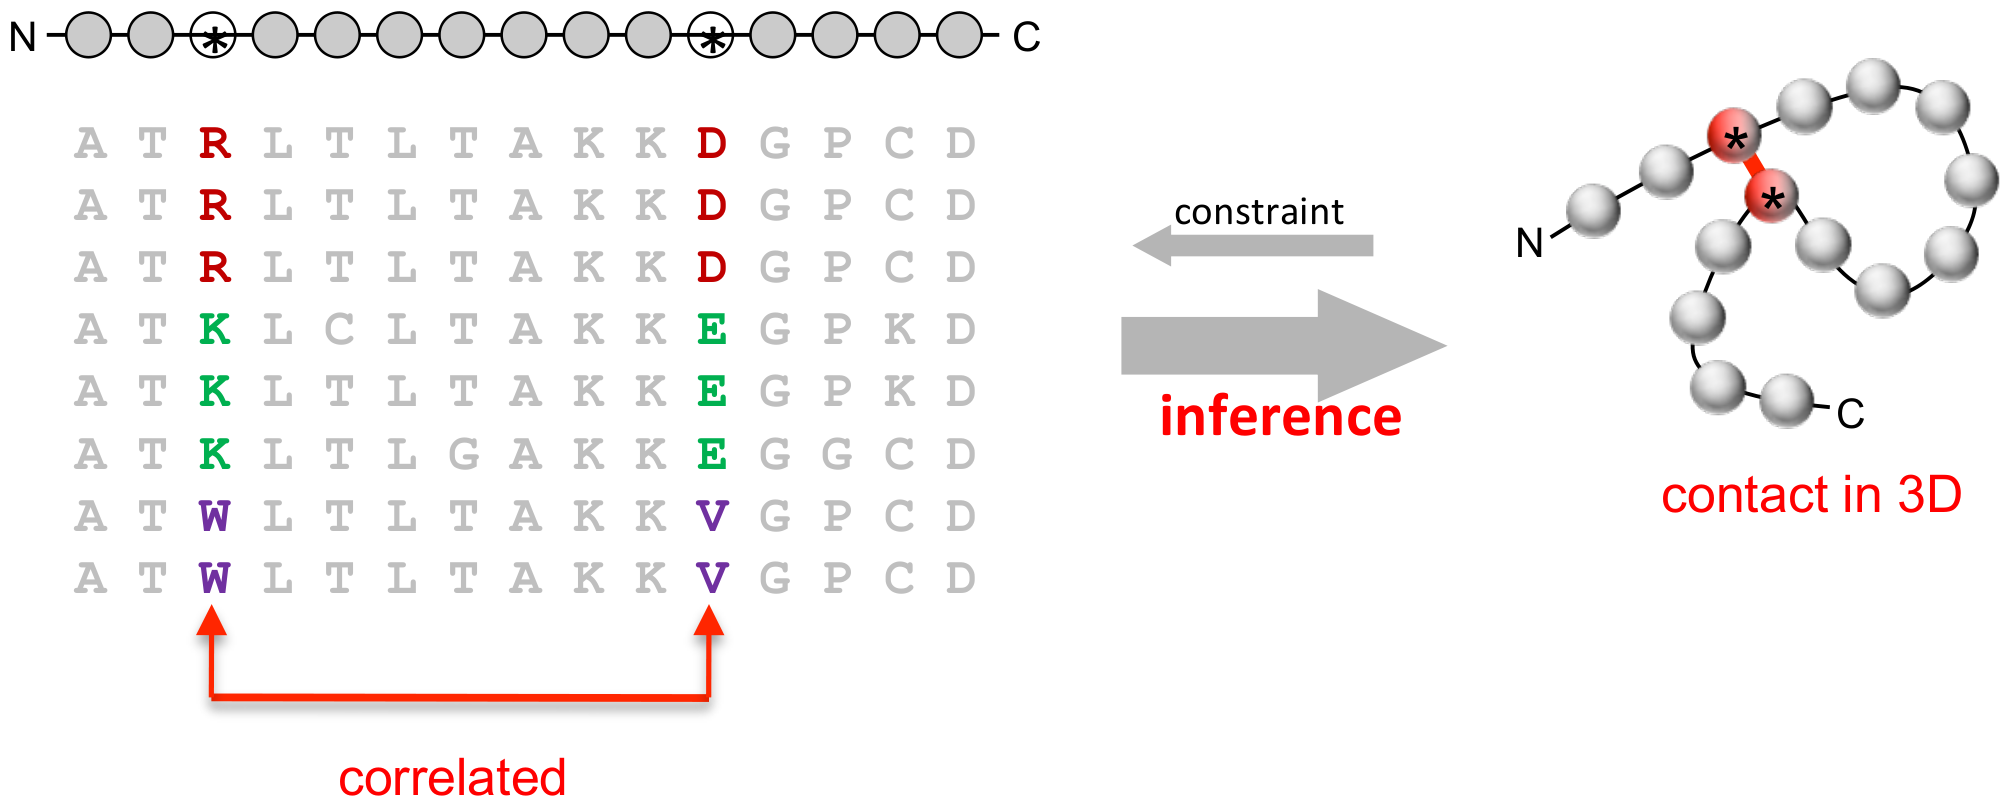

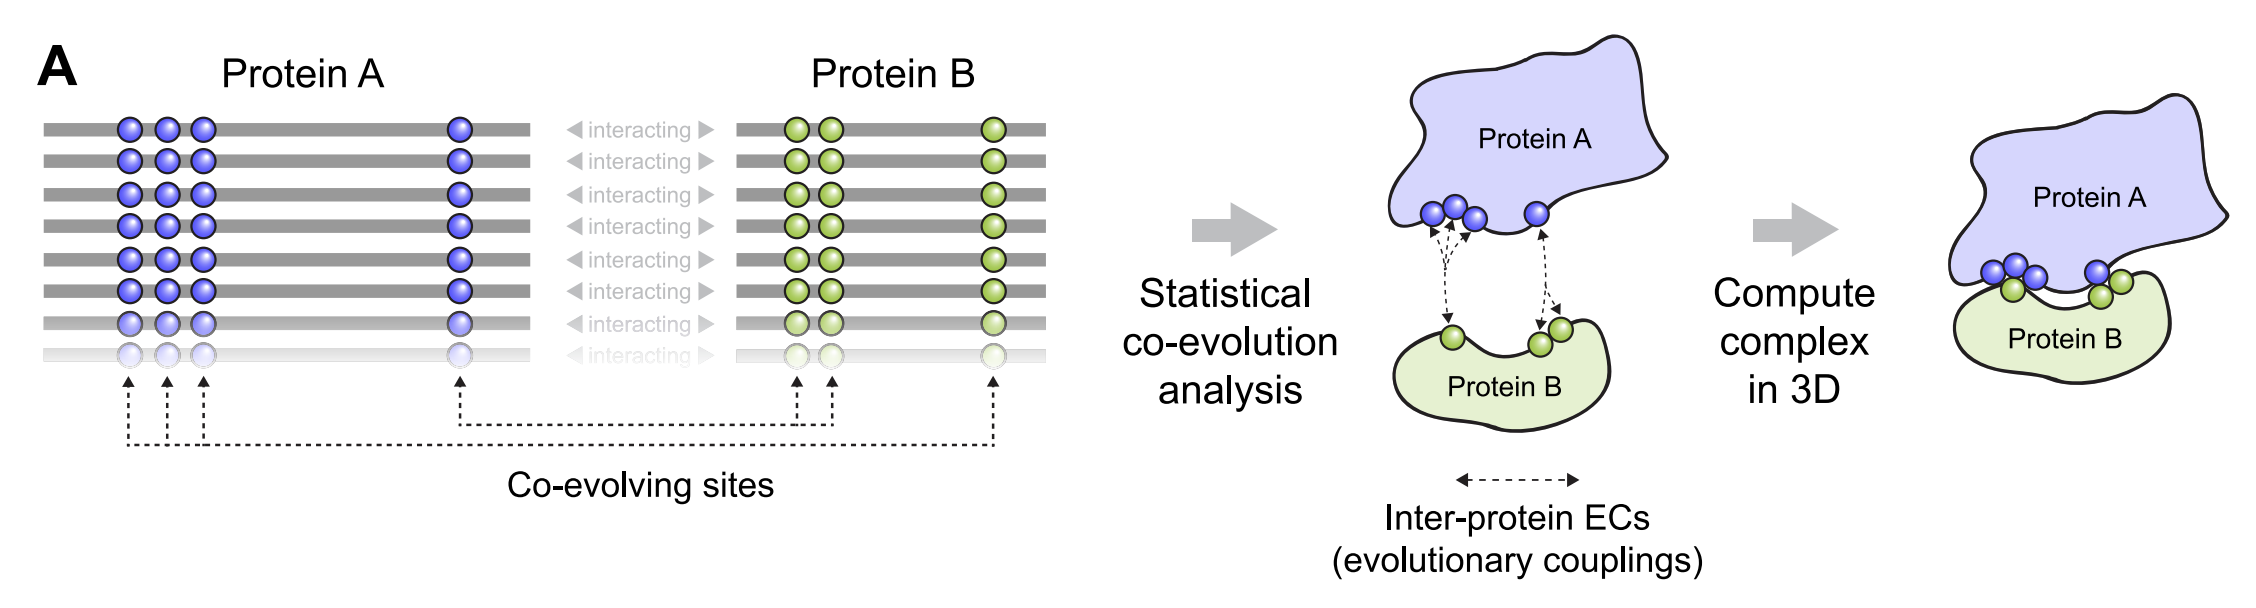

#### Row-wise

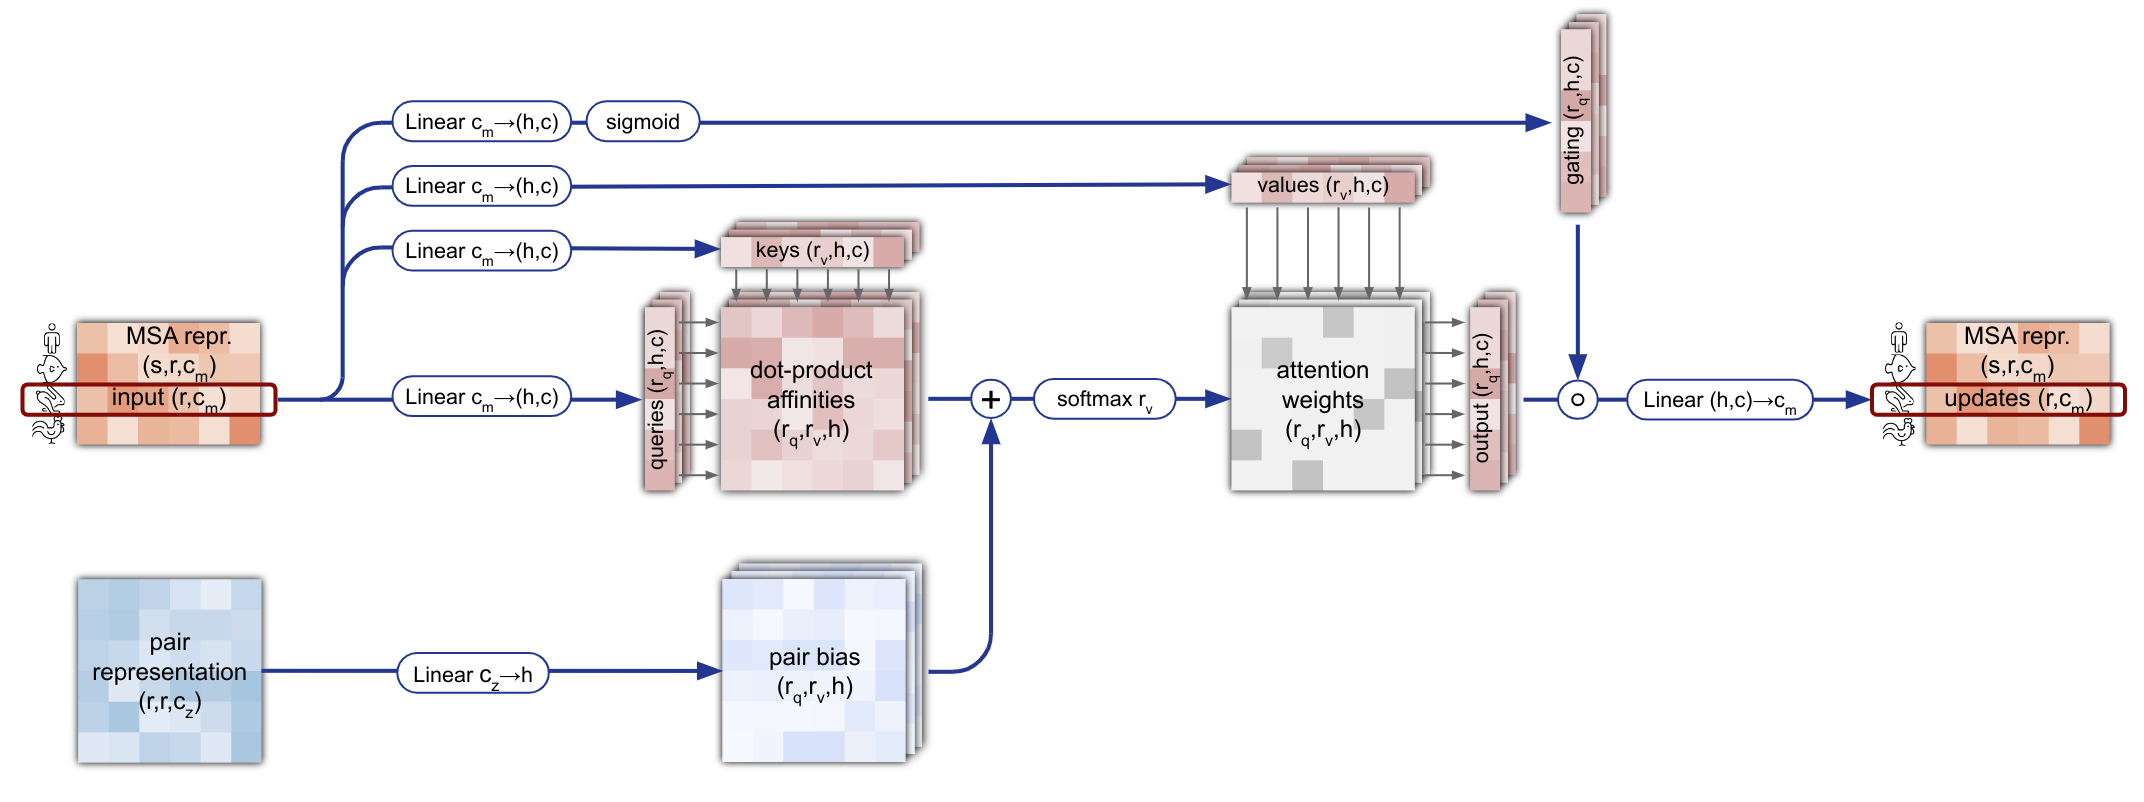

In [ ]:
# Algorithm 7
class MSARowAttention(nn.Module):

    def __init__(self, msa_dim, z_dim, dim_hid, n_head):

        super().__init__()

        self.n_head = n_head
        self.dim_hid = torch.tensor(dim_hid)

        self.msa_layer_norm = nn.LayerNorm(msa_dim)
        self.z_layer_norm = nn.LayerNorm(z_dim)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        self.W_Q = nn.Linear(msa_dim, n_head * dim_hid, bias=False)
        self.W_K = nn.Linear(msa_dim, n_head * dim_hid, bias=False)
        self.W_V = nn.Linear(msa_dim, n_head * dim_hid, bias=False)
        self.W_b = nn.Linear(z_dim, n_head, bias=False)
        self.W_g = nn.Linear(msa_dim, n_head * dim_hid)
        self.W_O = nn.Linear(n_head * dim_hid, msa_dim)

    def forward(self, msa, z):
        msa = self.msa_layer_norm(msa)
        Q, K, V = self.W_Q(msa), self.W_K(msa), self.W_V(msa)
        b = self.W_b(self.z_layer_norm(z))
        g = self.sigmoid(self.W_g(msa))

        Q = rearrange(Q, "s i (h c) -> h s i c", h=self.n_head)
        K = rearrange(K, "s i (h c) -> h s i c", h=self.n_head)
        V = rearrange(V, "s i (h c) -> h s i c", h=self.n_head)

        a = torch.einsum("h s i c, h s j c -> h s i j", Q, K) / torch.sqrt(self.dim_hid)
        b = repeat(b, "i j h -> h s i j", s=msa.shape[0])
        a = self.softmax(a + b)
        o = torch.einsum("h s i j, h s j c -> h s i c", a, V)
        o = rearrange(o, "h s i c -> s i (h c)")
        return self.W_O(g * o)


In [ ]:
msa = torch.randn(Nseq, L, cm)
z = torch.randn(L, L, cz)
msa_row_attn = MSARowAttention(cm, cz, c_msa_attn, Nhead_msa)

msa = msa_row_attn(msa, z)
msa.shape

torch.Size([10, 18, 256])

In [ ]:
# Unit test?
Q = torch.randn(Nhead_msa, Nseq, L, c_msa_attn)
K = torch.randn(Nhead_msa, Nseq, L, c_msa_attn)
a = torch.einsum("h s i c, h s j c -> h s i j", Q, K)

h, s, i, j = 1, 2, 3, 4
torch.isclose(a[1,2,3,4], torch.matmul(Q[h,s,i].T, K[h,s,j]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)



tensor(True)

#### Column-wise

Figure from [here](https://site.solab.org/research)

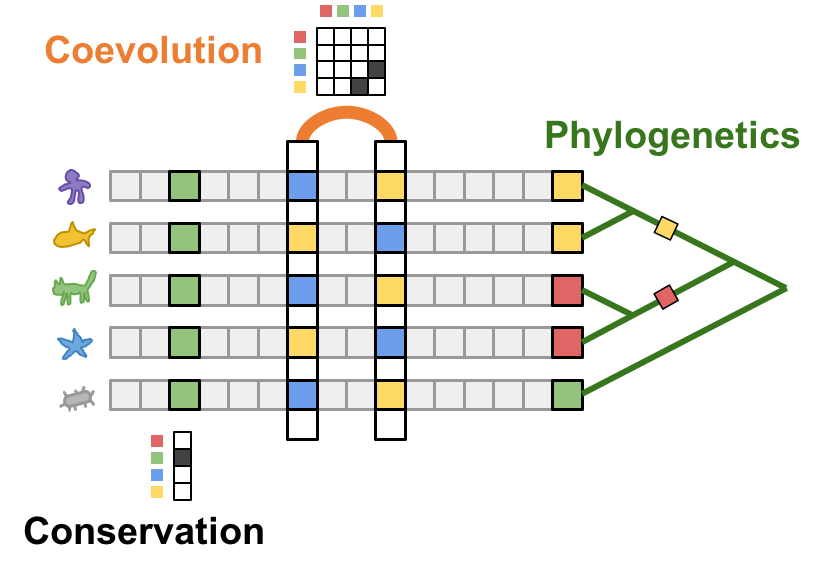

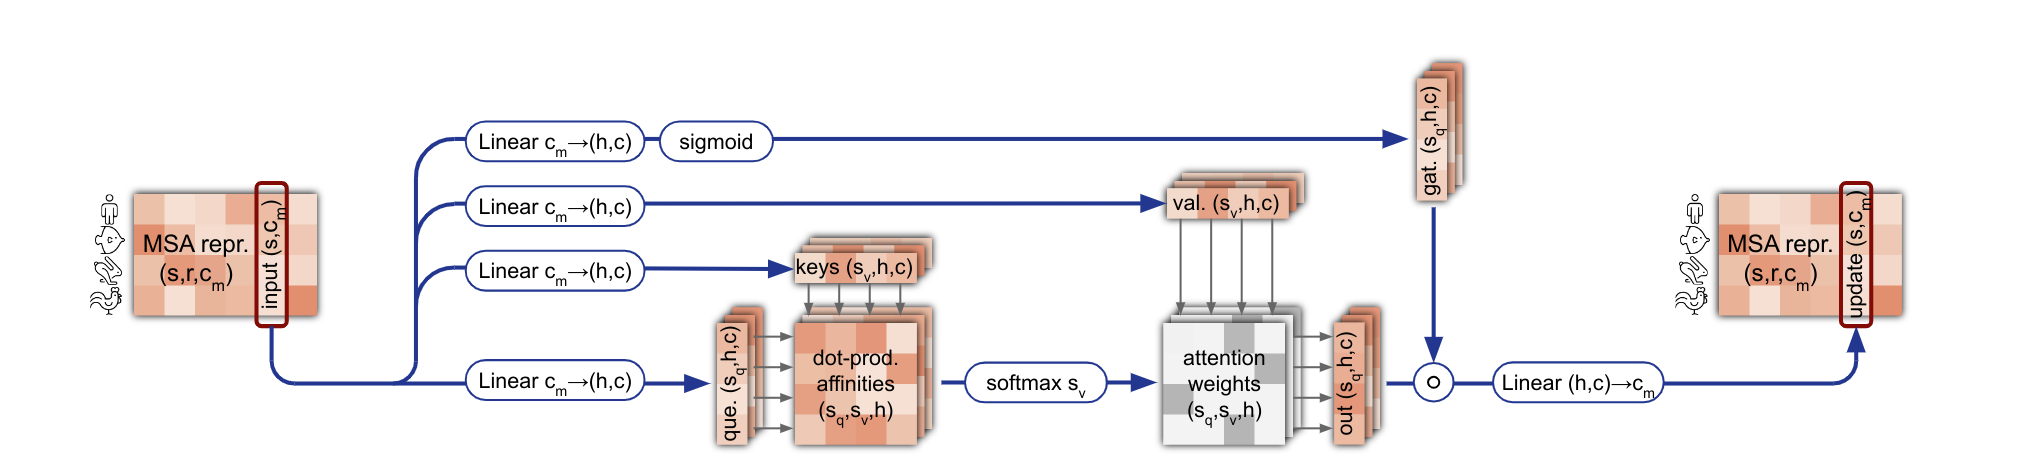

In [ ]:
# Algorithm 8
class MSAColumnAttention(nn.Module):

    def __init__(self, dim_in, dim_hid, n_head):

        super().__init__()

        self.n_head = n_head
        self.dim_hid = torch.tensor(dim_hid)

        self.layer_norm = nn.LayerNorm(dim_in)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-2)

        self.W_Q = nn.Linear(dim_in, n_head * dim_hid, bias=False)
        self.W_K = nn.Linear(dim_in, n_head * dim_hid, bias=False)
        self.W_V = nn.Linear(dim_in, n_head * dim_hid, bias=False)
        self.W_g = nn.Linear(dim_in, n_head * dim_hid)
        self.W_O = nn.Linear(n_head * dim_hid, dim_in)

    def forward(self, msa):
        msa = self.layer_norm(msa)
        Q, K, V = self.W_Q(msa), self.W_K(msa), self.W_V(msa)
        g = self.sigmoid(self.W_g(msa))

        Q = rearrange(Q, "s i (h c) -> h s i c", h=self.n_head)
        K = rearrange(K, "s i (h c) -> h s i c", h=self.n_head)
        V = rearrange(V, "s i (h c) -> h s i c", h=self.n_head)

        a = torch.einsum("h s i c, h t i c -> h s t i", Q, K) / torch.sqrt(self.dim_hid)
        a = self.softmax(a)
        o = torch.einsum("h s t i, h t i c -> h s i c", a, V) # TODO: this assumes the supp info has a typo at Line 5: v_st doesn't make sense
        o = rearrange(o, "h s i c -> s i (h c)")
        return self.W_O(g * o)


In [ ]:
msa = torch.randn(Nseq, L, cm)
msa_col_attn = MSAColumnAttention(cm, c_msa_attn, Nhead_msa)

msa = msa_col_attn(msa)
msa.shape

torch.Size([10, 18, 256])

## Transition, Outer Product Mean

Transition block

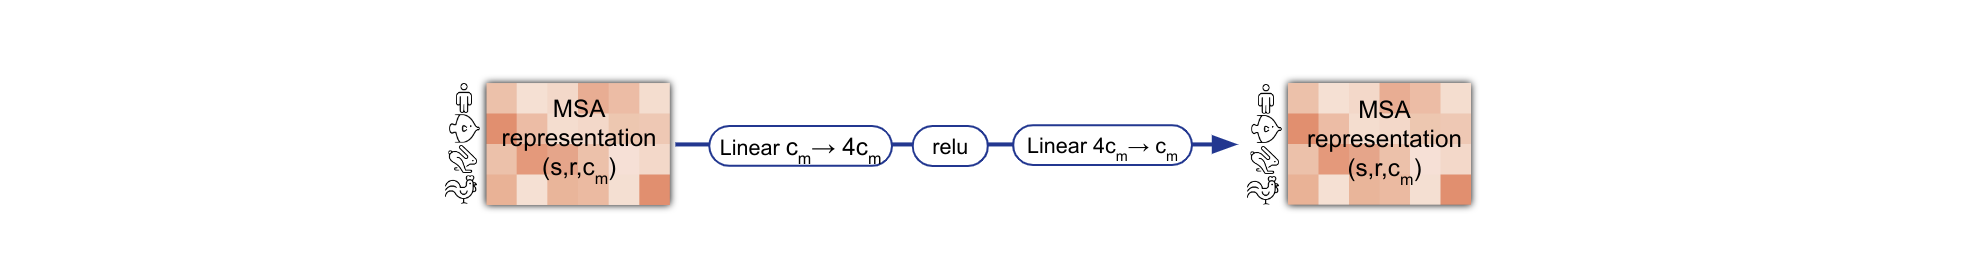

In [ ]:
# Algorithm 9, 15
class Transition(nn.Module):
    def __init__(self, dim_in, dim_hid):

        super().__init__()

        self.layer_norm = nn.LayerNorm(dim_in)

        self.W1 = nn.Linear(dim_in, dim_hid)
        self.relu = nn.ReLU()
        self.W2 = nn.Linear(dim_hid, dim_in)

    def forward(self, msa):
        msa = self.layer_norm(msa)
        a = self.W1(msa)
        return self.W2(self.relu(a))

In [ ]:
msa = torch.randn(Nseq, L, cm)
msa_transition = Transition(cm, 4*cm)

msa = msa_transition(msa)
msa.shape

torch.Size([10, 18, 256])

In [ ]:
z = torch.randn(L, L, cz)
pair_transition = Transition(cz, 4*cz)

z = pair_transition(z)
z.shape

torch.Size([18, 18, 128])

Outer product mean

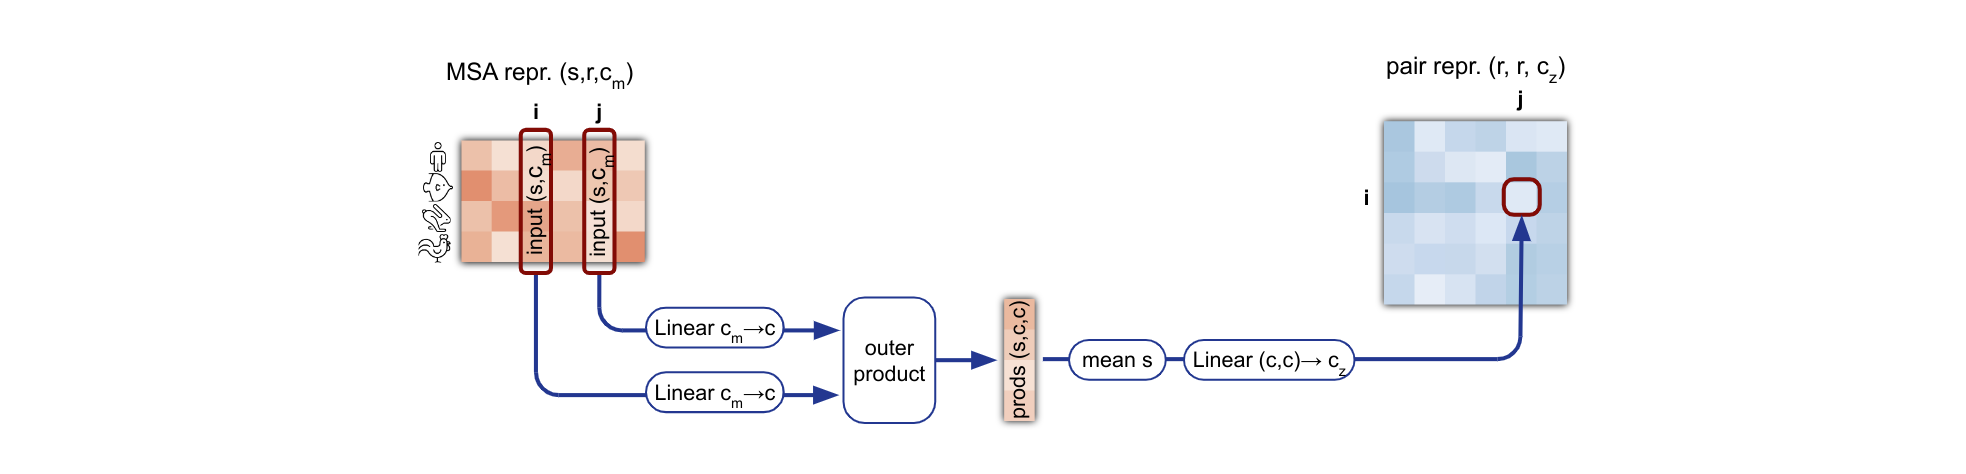

In [ ]:
# Algorithm 10
class OuterProductMean(nn.Module):
    def __init__(self, dim_in, dim_hid, dim_out):

        super().__init__()

        self.layer_norm = nn.LayerNorm(dim_in)

        self.W1 = nn.Linear(dim_in, dim_hid)
        self.W2 = nn.Linear(dim_in, dim_hid)
        self.W3 = nn.Linear(dim_hid * dim_hid, dim_out)

    def forward(self, msa):
        msa = self.layer_norm(msa)
        a, b = self.W1(msa), self.W2(msa)
        o = torch.einsum("s i c, s j d -> s i j c d", a, b)
        o = reduce(o, "s i j c d -> i j (c d)", reduction="mean")
        return self.W3(o)


In [ ]:
msa = torch.randn(Nseq, L, cm)
outer_product_mean = OuterProductMean(cm, c_outer_product, cz)

z = outer_product_mean(msa)
z.shape

torch.Size([18, 18, 128])

## Triangle Multiplicative Updates

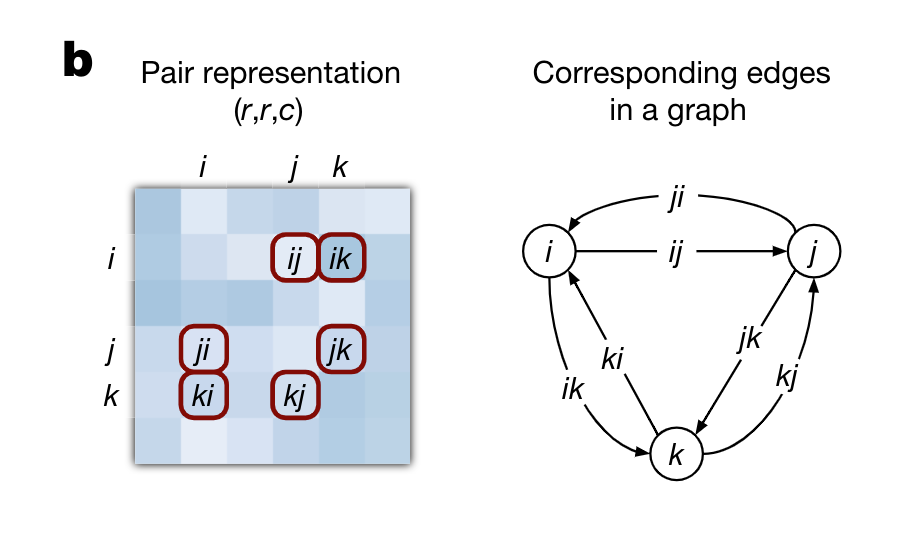

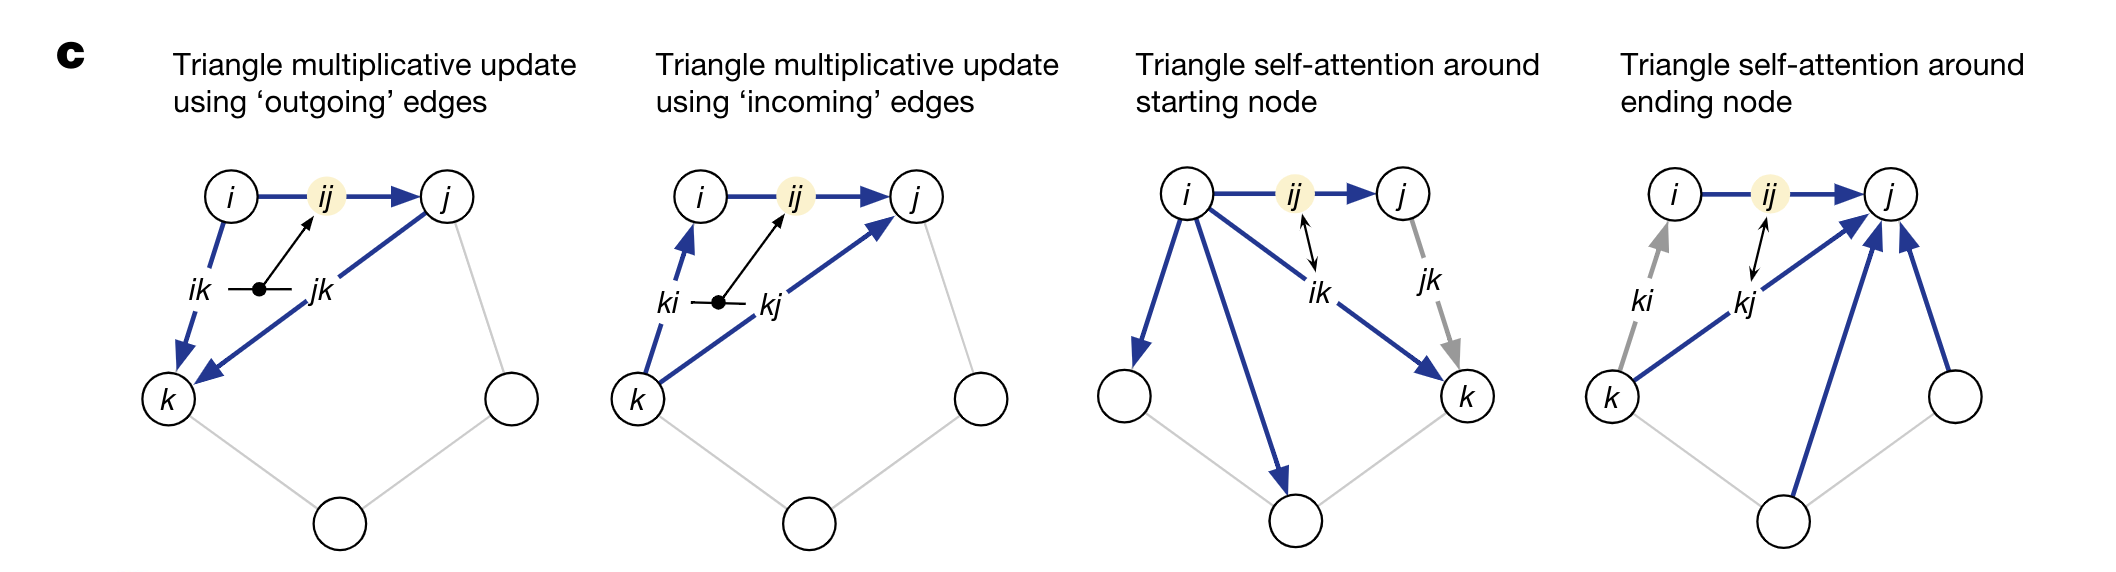

In [ ]:
# Algorithm 11, 12
class TriangleMultiplication(nn.Module):

    def __init__(self, dim_in, dim_hid, outgoing: bool = True):

        super().__init__()

        self.layer_norm_in = nn.LayerNorm(dim_in)
        self.layer_norm_hid = nn.LayerNorm(dim_hid)

        self.W1 = nn.Linear(dim_in, dim_hid)
        self.W2 = nn.Linear(dim_in, dim_hid)
        self.W3 = nn.Linear(dim_hid, dim_in)
        self.gate_a = nn.Linear(dim_in, dim_hid)
        self.gate_b = nn.Linear(dim_in, dim_hid)
        self.gate_z = nn.Linear(dim_in, dim_in)
        self.sigmoid = nn.Sigmoid()

        if outgoing:
            self.formula = "i k c, j k c -> i j c"
        else:
            self.formula = "k i c, k j c -> i j c"

    def forward(self, z):
        z = self.layer_norm_in(z)
        a = self.sigmoid(self.gate_a(z)) * self.W1(z)
        b = self.sigmoid(self.gate_b(z)) * self.W2(z)
        g = self.sigmoid(self.gate_z(z))
        mult = torch.einsum(self.formula, a, b)
        return g * self.W3(self.layer_norm_hid(mult))


In [ ]:
triangle_mult_outgoing = TriangleMultiplication(cz, c_triangle_mult, outgoing=True)
triangle_mult_incoming = TriangleMultiplication(cz, c_triangle_mult, outgoing=False)

In [ ]:
z = torch.randn(L, L, cz)
triangle_mult_outgoing(z).shape

torch.Size([18, 18, 128])

In [ ]:
z = torch.randn(L, L, cz)
triangle_mult_incoming(z).shape

torch.Size([18, 18, 128])

## Triangle Attention

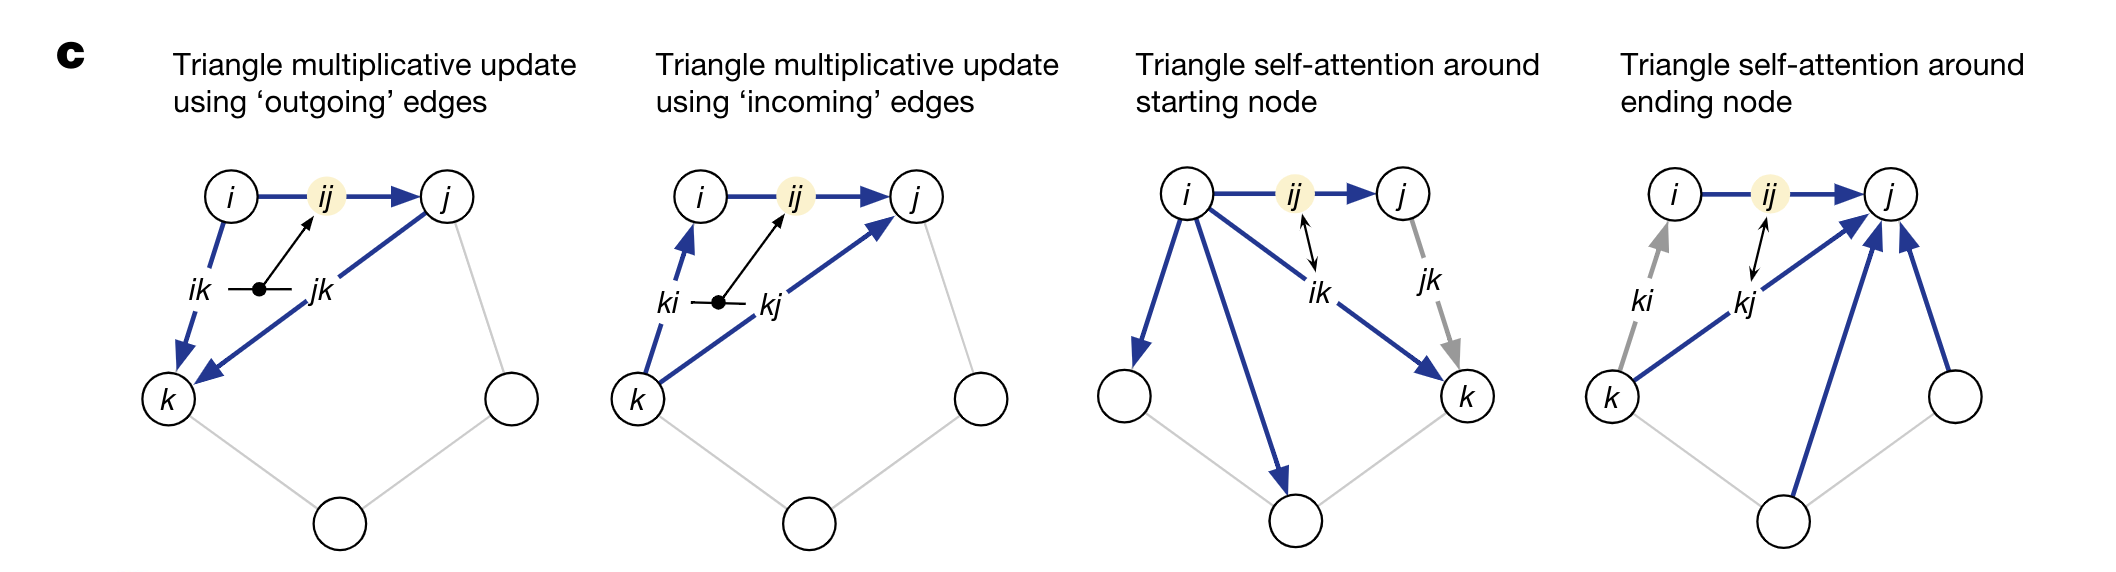

In [ ]:
# Algorithm 13, 14
class TriangleAttention(nn.Module):

    def __init__(self, dim_in, dim_hid, n_head, starting: bool = True):

        super().__init__()

        self.starting = starting

        self.dim_hid = torch.tensor(dim_hid)
        self.n_head = n_head

        self.layer_norm = nn.LayerNorm(dim_in)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        self.W_Q = nn.Linear(dim_in, n_head * dim_hid, bias=False)
        self.W_K = nn.Linear(dim_in, n_head * dim_hid, bias=False)
        self.W_V = nn.Linear(dim_in, n_head * dim_hid, bias=False)
        self.W_b = nn.Linear(dim_in, n_head, bias=False)
        self.W_g = nn.Linear(dim_in, n_head * dim_hid)
        self.W_O = nn.Linear(n_head * dim_hid, dim_in)

    def forward(self, z):
        z = self.layer_norm(z)
        Q, K, V = self.W_Q(z), self.W_K(z), self.W_V(z)
        b = self.W_b(z)
        g = self.sigmoid(self.W_g(z))

        Q = rearrange(Q, "i j (h c) -> h i j c", h=self.n_head)
        K = rearrange(K, "i j (h c) -> h i j c", h=self.n_head)
        V = rearrange(V, "i j (h c) -> h i j c", h=self.n_head)
        b = rearrange(b, "i j h -> h i j")
        g = rearrange(g, "i j (h c) -> h i j c", h=self.n_head)
        if self.starting:
            a = torch.einsum("h i j c, h i k c -> h i j k", Q, K) / torch.sqrt(self.dim_hid)
            b = repeat(b, "h j k -> h i j k", i=z.shape[0])
            a = self.softmax(a + b)
            o = g * torch.einsum("h i j k, h i k c -> h i j c", a, V)
        else:
            a = torch.einsum("h i j c, h k j c -> h i j k", Q, K) / torch.sqrt(self.dim_hid)
            b = repeat(b, "h k i -> h i j k", j=z.shape[1])
            a = self.softmax(a + b)
            o = g * torch.einsum("h i j k, h k j c -> h i j c", a, V)
        o = rearrange(o, "h i j c -> i j (h c)")
        return self.W_O(o)


In [ ]:
triangle_attention_starting = TriangleAttention(cz, c_triangle_attn, Nhead_triangle, starting=True)
triangle_attention_ending = TriangleAttention(cz, c_triangle_attn, Nhead_triangle, starting=False)

In [ ]:
z = torch.randn(L, L, cz)
triangle_attention_starting(z).shape

torch.Size([18, 18, 128])

In [ ]:
z = torch.randn(L, L, cz)
triangle_attention_ending(z).shape

torch.Size([18, 18, 128])

### Custom Dropout

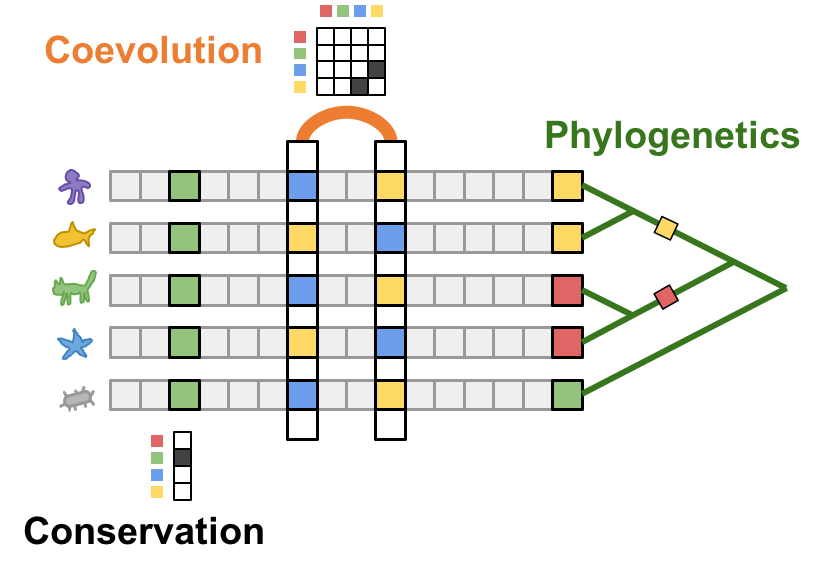

In [ ]:
class DropoutRowwise(nn.Module):

    def __init__(self, p=0.15):

        super().__init__()

        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        h, w, c = x.shape
        mask = self.dropout(torch.ones(1, w, c))
        return mask * x


In [ ]:
class DropoutColumnwise(nn.Module):

    def __init__(self, p=0.15):

        super().__init__()

        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        h, w, c = x.shape
        mask = self.dropout(torch.ones(h, 1, c))
        return mask * x


## Evoformer

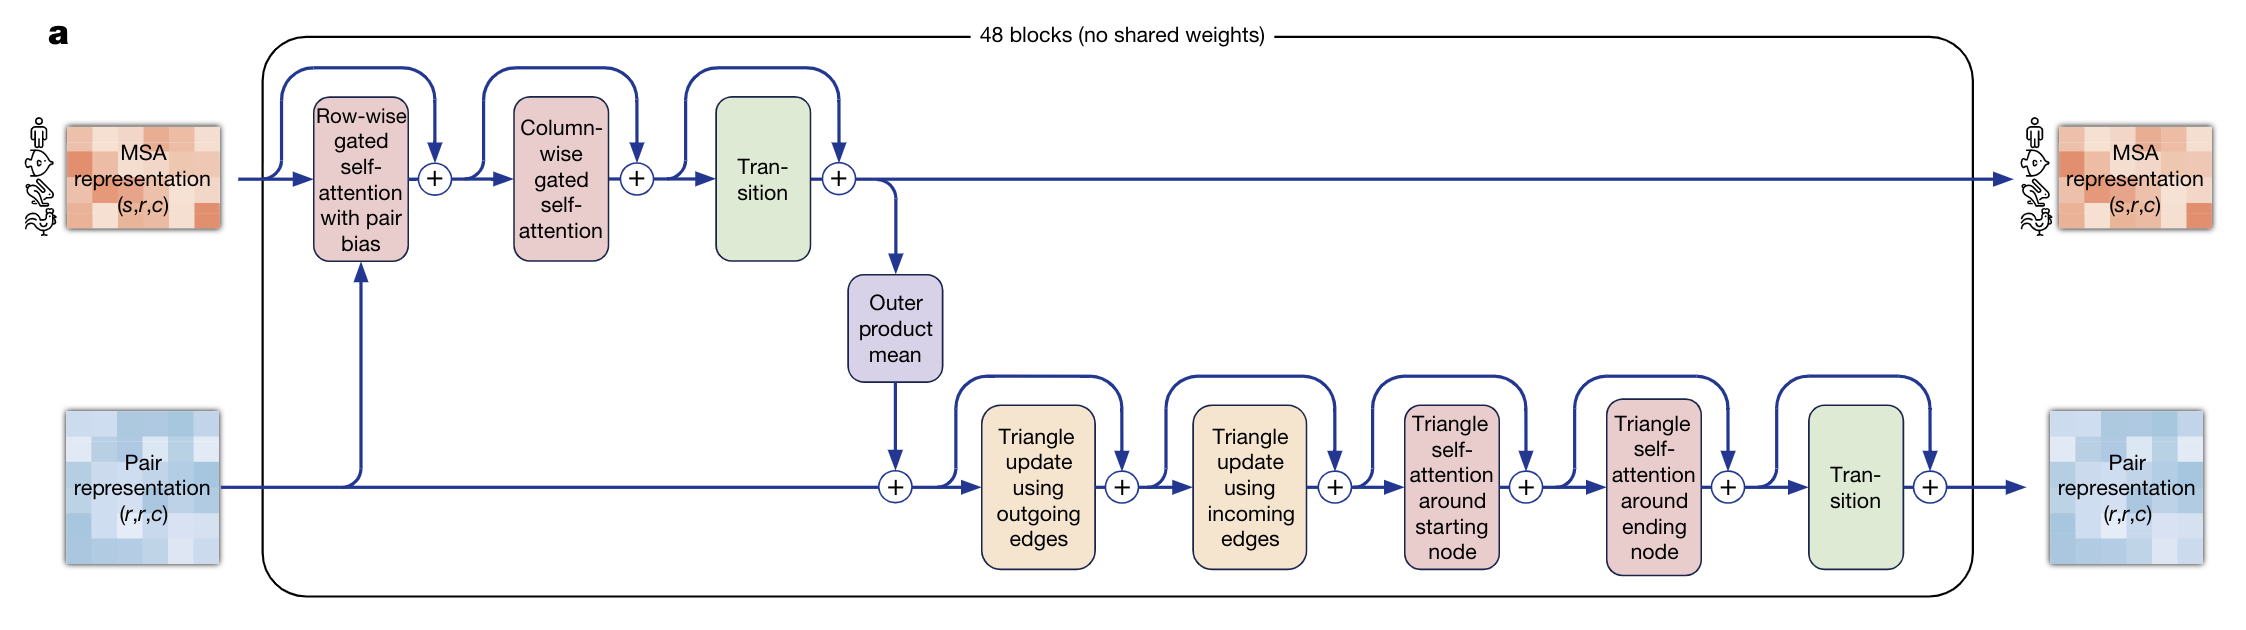

In [ ]:
# Algorithm 6
class Evoformer(nn.Module):

    def __init__(self, dim_msa, dim_z, dim_s, n_block):

        super().__init__()

        self.n_block = n_block

        self.dropout_rowwise_15 = nn.Dropout(p=0.15)
        self.dropout_rowwise_25 = nn.Dropout(p=0.25)
        self.dropout_colwise_25 = nn.Dropout(p=0.25)

        self.msa_row_attn = MSARowAttention(dim_msa, dim_z, c_msa_attn, Nhead_msa)
        self.msa_col_attn = MSAColumnAttention(dim_msa, c_msa_attn, Nhead_msa)
        self.msa_transition = Transition(dim_msa, 4*dim_msa)

        self.outer_product_mean = OuterProductMean(dim_msa, c_outer_product, dim_z)

        self.triangle_mult_outgoing = TriangleMultiplication(cz, c_triangle_mult, outgoing=True)
        self.triangle_mult_incoming = TriangleMultiplication(cz, c_triangle_mult, outgoing=False)
        self.triangle_attn_starting = TriangleAttention(cz, c_triangle_attn, Nhead_triangle, starting=True)
        self.triangle_attn_ending = TriangleAttention(cz, c_triangle_attn, Nhead_triangle, starting=False)

        self.pair_transition = Transition(cz, 4*cz)

        self.single_rep_layer = nn.Linear(dim_msa, dim_s)

    def forward(self, msa, z):
        Nseq, Nres, cm = msa.shape
        for _ in range(self.n_block):
            msa += self.dropout_rowwise_15(self.msa_row_attn(msa, z))
            msa += self.msa_col_attn(msa)
            msa += self.msa_transition(msa)
            z += self.outer_product_mean(msa)
            z += self.triangle_mult_outgoing(z)
            z += self.triangle_mult_incoming(z)
            z += self.triangle_attn_starting(z)
            z += self.triangle_attn_ending(z)
            z += self.pair_transition(z)
        s = self.single_rep_layer(msa[0, :, :])
        return msa, z, s


In [ ]:
evoformer = Evoformer(cm, cz, cs, Nevoformer_blocks)

msa = torch.randn(Nseq, L, cm)
z = torch.randn(L, L, cz)
msa, z, s = evoformer(msa, z)

print(msa.shape)
print(z.shape)
print(s.shape)

torch.Size([10, 18, 256])
torch.Size([18, 18, 128])
torch.Size([18, 384])


## Local frames of residue gas via the [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process)

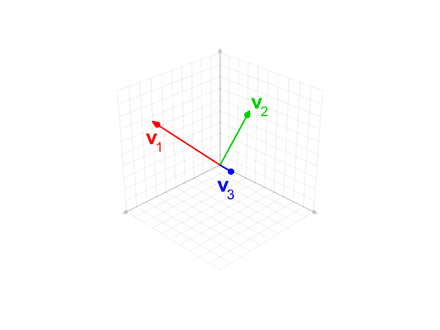

In [ ]:
# Algorithm 21
def rigidFrom3Points(x1, x2, x3):
    # x1: N, x2: Ca, x3: C
    v1 = x3 - x2
    v2 = x1 - x2
    e1 = v1 / torch.norm(v1)
    u2 = v2 - torch.matmul(e1, v2) * e1
    e2 = u2 / torch.norm(u2)
    e3 = torch.cross(e1, e2)
    R = torch.cat((e1[:, None], e2[:, None], e3[:, None]), dim=1)
    t = x2
    return (R, t)


In [ ]:
x1 = torch.tensor([1.0, 2.0, 3.0])
x2 = torch.tensor([-2.0, 1.0, 2.0])
x3 = torch.tensor([3.0, -1.0, 1.0])

R, t = rigidFrom3Points(x1, x2, x3)

In [ ]:
assert torch.all(torch.isclose(t, x2))
assert torch.isclose(torch.matmul(R[:, 0], R[:, 1]), torch.tensor(0.0), atol=1e-5)
assert torch.isclose(torch.matmul(R[:, 0], R[:, 2]), torch.tensor(0.0), atol=1e-5)
assert torch.isclose(torch.matmul(R[:, 1], R[:, 2]), torch.tensor(0.0), atol=1e-5)
assert torch.isclose(torch.norm(R[:, 0]), torch.tensor(1.0), atol=1e-5)
assert torch.isclose(torch.norm(R[:, 1]), torch.tensor(1.0), atol=1e-5)
assert torch.isclose(torch.norm(R[:, 2]), torch.tensor(1.0), atol=1e-5)

## Invariant Point Attention

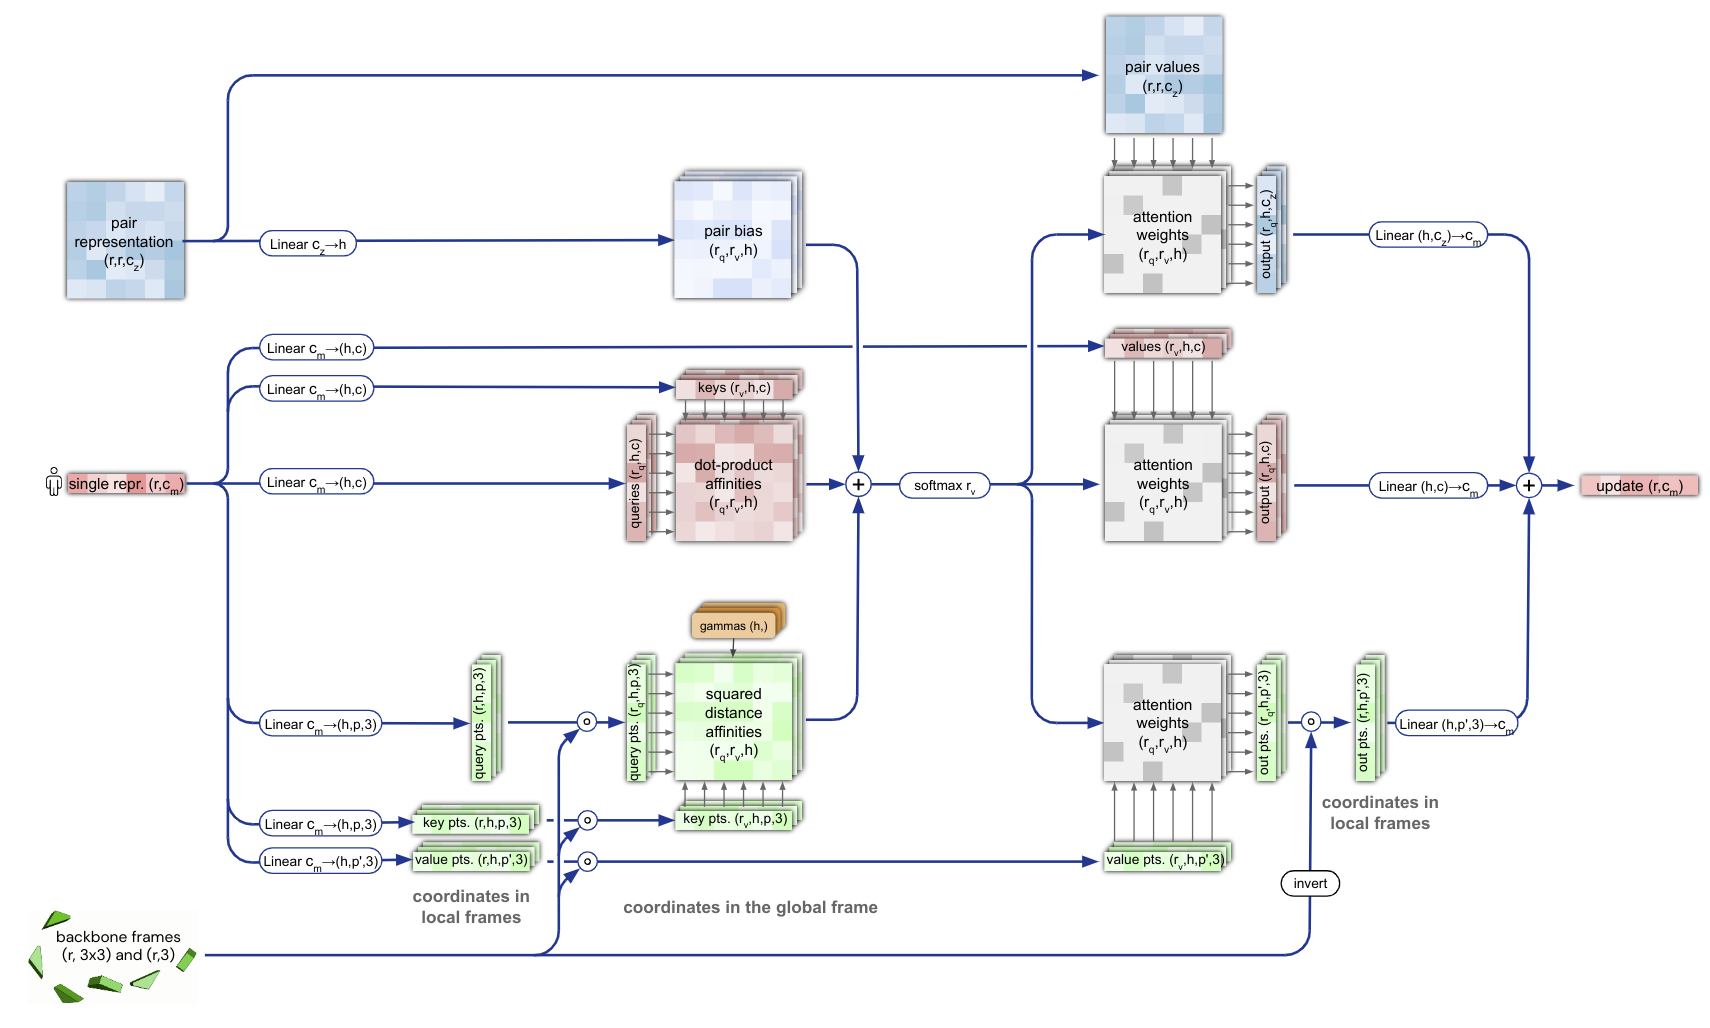

In [ ]:
# Algorithm 22
class InvariantPointAttention(nn.Module):

    def __init__(self, s_dim, z_dim, n_head, dim_hid, n_query_points, n_point_values):

        super().__init__()

        self.s_dim = s_dim
        self.z_dim = z_dim
        self.n_head = n_head
        self.dim_hid = torch.tensor(dim_hid)
        self.n_query_points = n_query_points
        self.n_point_values = n_point_values

        self.W_Q = nn.Linear(s_dim, n_head * dim_hid, bias=False)
        self.W_K = nn.Linear(s_dim, n_head * dim_hid, bias=False)
        self.W_V = nn.Linear(s_dim, n_head * dim_hid, bias=False)
        self.W_QP = nn.Linear(s_dim, n_head * n_query_points * 3, bias=False)
        self.W_KP = nn.Linear(s_dim, n_head * n_query_points * 3, bias=False)
        self.W_VP = nn.Linear(s_dim, n_head * n_point_values * 3, bias=False)
        self.W_b = nn.Linear(z_dim, n_head)
        self.wc = torch.sqrt(torch.tensor(2/(9*n_query_points)))
        self.wl = torch.sqrt(torch.tensor(1/3))
        self.gamma = nn.Parameter(torch.ones(n_head))[:, None, None]
        self.W_O = nn.Linear(self.n_head * (self.z_dim + self.dim_hid + 3 * (self.n_point_values) + 1 * (self.n_point_values)), self.s_dim)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, s, z, R, t): # R: L rotation matrices, t: L translation vectors
        R_inv = torch.cat(tuple(torch.inverse(r).unsqueeze(0) for r in R), dim=0)
        t_inv = torch.cat(tuple((-r_inv @ t[i]).unsqueeze(0) for i, r_inv in enumerate(R_inv)), dim=0)
        Q, K, V = self.W_Q(s), self.W_K(s), self.W_V(s)
        QP, KP, VP = self.W_QP(s), self.W_KP(s), self.W_VP(s)
        bias = self.W_b(z)

        Q = rearrange(Q, "i (h c) -> h i c", h=self.n_head)
        K = rearrange(K, "i (h c) -> h i c", h=self.n_head)
        V = rearrange(V, "i (h c) -> h i c", h=self.n_head)

        QP = rearrange(QP, "i (h p c) -> i h p c", h=self.n_head, p=self.n_query_points)
        KP = rearrange(KP, "i (h p c) -> i h p c", h=self.n_head, p=self.n_query_points)
        VP = rearrange(VP, "i (h p c) -> i h p c", h=self.n_head, p=self.n_point_values)

        attn = torch.einsum("h i c, h j c -> h i j", Q, K) / torch.sqrt(self.dim_hid)

        Q_global = torch.einsum("i a b, i h p b -> i h p a", R, QP)
        K_global = torch.einsum("i a b, i h p b -> i h p a", R, KP)
        V_global = torch.einsum("i a b, i h p b -> h p i a", R, VP)
        dists = torch.zeros(len(s), len(s), self.n_head, self.n_query_points)
        for i, j in itertools.product(range(len(s)), range(len(s))):
            tq = Q_global[i] + t[i].view(1, 1, 3)
            tk = K_global[j] + t[j].view(1, 1, 3)
            dists[i, j] = torch.norm(tq - tk)
        dists = reduce(dists, "i j h p -> h i j", reduction="sum")
        dists = self.gamma * self.wc * dists / 2.0
        bias = rearrange(bias, "i j h -> h i j")
        a = self.softmax(self.wl * (attn + bias - dists))
        oz = torch.einsum("h i j, i j c -> h i c ", a, z)
        ov = torch.einsum("h i j, h j c -> h i c", a, V)
        op = torch.einsum("h i j, h p j c -> h p i c", a, V_global)
        R_inv = repeat(R_inv, "i a b -> h p i a b", h=self.n_head, p=self.n_point_values)
        op = torch.einsum("h p i a b, h p i b -> h p i a", R_inv, op)
        op_norm = torch.norm(op, dim=-1)
        oz = rearrange(oz, "h i c -> i (h c)")
        ov = rearrange(ov, "h i c -> i (h c)")
        op = rearrange(op, "h p i c -> i (h p c)")
        op_norm = rearrange(op_norm, "h p i -> i (h p)")
        o = torch.cat((oz, ov, op, op_norm), -1)
        s = self.W_O(o)
        return s


In [ ]:
ipa = InvariantPointAttention(cs, cz, Nhead_ipa, c_ipa, Nquery_pts, Nvalue_pts)
s = torch.randn(L, cs)
z = torch.randn(L, L, cz)
R = torch.randn(L, 3, 3)
t = torch.randn(L, 3)

s = ipa(s, z, R, t)
s.shape

torch.Size([18, 384])

In [ ]:
# Algorithm 23
# See https://eater.net/quaternions for mind-bending videos on quaternions
class BackboneUpdate(nn.Module):

    def __init__(self, dim_in):

        super().__init__()

        self.linear_b = nn.Linear(dim_in, 1)
        self.linear_c = nn.Linear(dim_in, 1)
        self.linear_d = nn.Linear(dim_in, 1)
        self.linear_t = nn.Linear(dim_in, 3)

    def forward(self, s):
        b = self.linear_b(s)
        c = self.linear_c(s)
        d = self.linear_d(s)
        t = self.linear_t(s)

        root = torch.sqrt(1 + b**2 + c**2 + d**2)
        a, b, c, d = 1/root, b/root, c/root, d/root
        R_00 = a**2 + b**2 - c**2 - d**2
        R_01 = 2*b*c - 2*a*d
        R_02 = 2*b*d + 2*a*c
        R_10 = 2*b*c + 2*a*d
        R_11 = a**2 - b**2 + c**2 - d**2
        R_12 = 2*c*d - 2*a*b
        R_20 = 2*b*d - 2*a*c
        R_21 = 2*c*d - 2*a*b
        R_22 = a**2 - b**2 - c**2 + d**2
        R = torch.cat((R_00, R_01, R_02, R_10, R_11, R_12, R_20, R_21, R_22), dim=-1)
        R = rearrange(R, "i (m n) -> i m n", m=3)
        return R, t


In [ ]:
backbone_update = BackboneUpdate(cs)
s = torch.randn(L, cs)

R, t = backbone_update(s)
print(R.shape)
print(t.shape)

torch.Size([18, 3, 3])
torch.Size([18, 3])


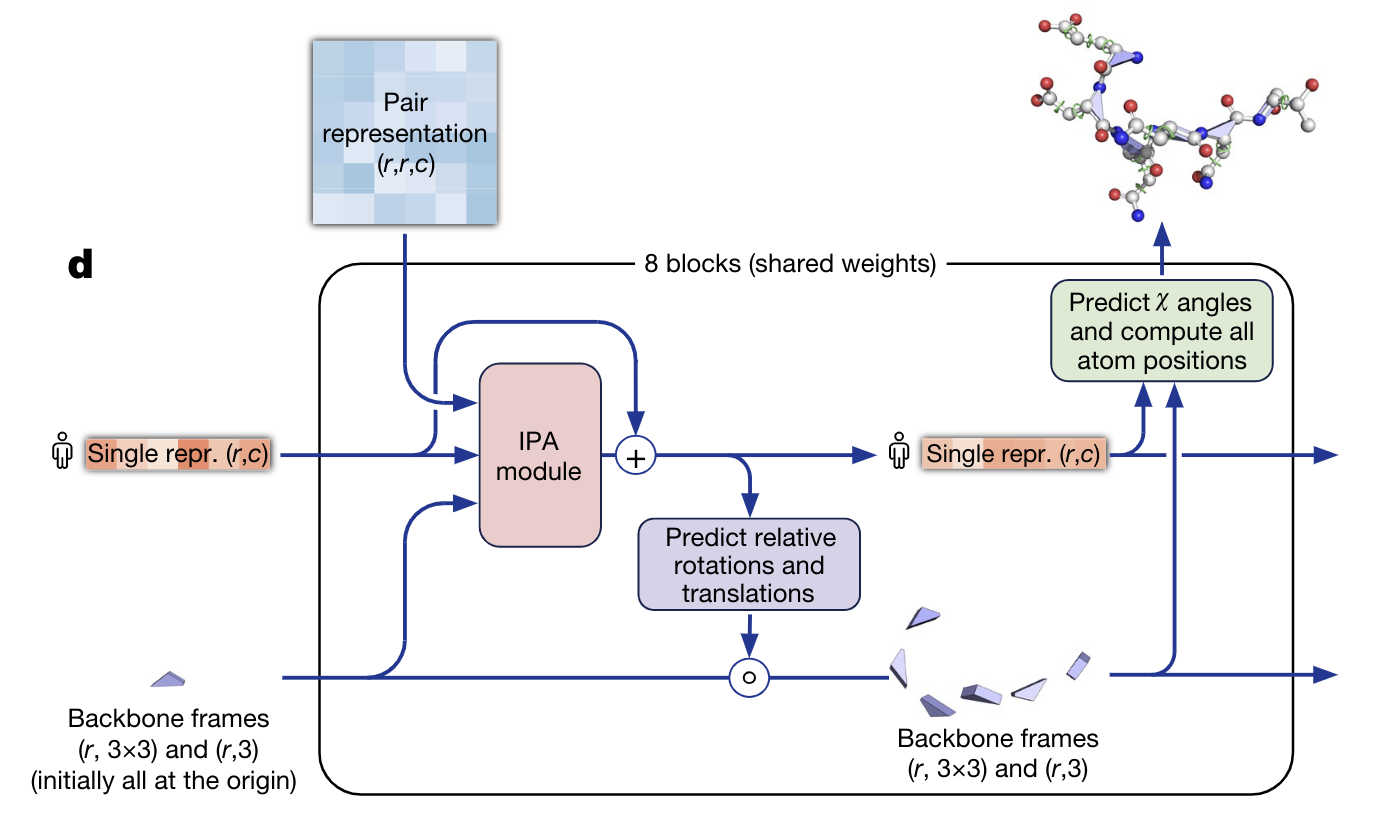

In [ ]:
# Algorithm 20 (until line 15)
class StructureModule(nn.Module):

    def __init__(self, s_dim, z_dim, n_layer, dim_hid, num_torsions=7):

        super().__init__()

        self.n_layer = n_layer

        self.s_layer_norm = nn.LayerNorm(s_dim)
        self.z_layer_norm = nn.LayerNorm(z_dim)
        self.W0 = nn.Linear(s_dim, s_dim)

        self.ipa = InvariantPointAttention(s_dim, z_dim, Nhead_ipa, c_ipa, Nquery_pts, Nvalue_pts)
        self.S1 = nn.Linear(s_dim, s_dim)
        self.S2 = nn.Linear(s_dim, s_dim)
        self.S3 = nn.Linear(s_dim, s_dim)
        self.bb_update = BackboneUpdate(s_dim)

        self.SA1 = nn.Linear(s_dim, dim_hid)
        self.SA2 = nn.Linear(s_dim, dim_hid)
        self.A1 = nn.Linear(dim_hid, dim_hid)
        self.A2 = nn.Linear(dim_hid, dim_hid)
        self.A3 = nn.Linear(dim_hid, dim_hid)
        self.A4 = nn.Linear(dim_hid, dim_hid)
        self.A5 = nn.Linear(dim_hid, num_torsions * 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, s, z):
        s_init = self.s_layer_norm(s)
        z = self.z_layer_norm(z)
        s = self.W0(s_init)
        R = torch.eye(3)
        t = torch.zeros(3)
        R = repeat(R, "a b -> i a b", i=s.shape[-2])
        t = repeat(t, "b -> i b", i=s.shape[-2])
        for l in range(self.n_layer):
            s = self.ipa(s, z, R, t)
            s = self.s_layer_norm(self.dropout(s))
            s = s + self.S3(self.relu(self.S2(self.relu(self.S1(s)))))
            s = self.s_layer_norm(self.dropout(s))
            R_, t_ = self.bb_update(s)
            t = torch.einsum("i a b, i b -> i a", R, t_) + t
            R = torch.einsum("i a b, i b c -> i a c", R, R_)
            a = self.SA1(s) + self.SA2(s_init)
            a = a + self.A2(self.relu(self.A1(self.relu(a))))
            a = a + self.A4(self.relu(self.A3(self.relu(a))))
            rotamers = self.A5(self.relu(a))
            if l < self.n_layer - 1:
                R = R.detach()
        return s, R, t, rotamers


In [ ]:
structure_module = StructureModule(cs, cz, Nstructure_module, c_structure_module)

s = torch.randn(L, cs)
z = torch.randn(L, L, cz)
s, R, t, rotamers = structure_module(s, z)

print(s.shape)
print(R.shape)
print(t.shape)
print(rotamers.shape)

torch.Size([18, 384])
torch.Size([18, 3, 3])
torch.Size([18, 3])
torch.Size([18, 14])


## Recycling

In [ ]:
# Algorithm 32
class RecyclingEmbedder(nn.Module):

    def __init__(self, v_bins, msa_dim, z_dim):

        super().__init__()

        self.v_bins = v_bins

        self.linear = nn.Linear(len(v_bins), z_dim)
        self.pair_norm = nn.LayerNorm(z_dim)
        self.msa_norm = nn.LayerNorm(msa_dim)

    def forward(self, msa_first_row, z, coords):
        Nres = len(coords)
        d = torch.zeros(Nres, Nres, len(v_bins))
        for i, j in itertools.product(range(Nres), range(Nres)):
            dist = torch.norm(coords[i] - coords[j])
            d[i, j] = one_hot(dist, v_bins)
        d = self.linear(d)
        z = d + self.pair_norm(z)
        msa_first_row = self.msa_norm(msa_first_row)
        return msa_first_row, z


In [ ]:
v_bins = torch.linspace(3 + 3/8, 21 + 3/8, 16)
recycling_embedder = RecyclingEmbedder(v_bins, cm, cz)

msa = torch.randn(Nseq, L, cm)
msa_first_row = msa[0, :, :]
z = torch.randn(L, L, cz)
coords = torch.randn(L, 3)

msa_first_row, z = recycling_embedder(msa_first_row, z, coords)
print(msa_first_row.shape)
print(z.shape)

torch.Size([18, 256])
torch.Size([18, 18, 128])


In [ ]:
def get_target_feat():
    pass

def get_